In [45]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
import json

onlyfiles = [
    f for f in listdir("./real-data-copy") if isfile(join("./real-data-copy", f))
]


print(len(onlyfiles))
onlyfiles[:5]

265


['csv-2023-12-15-10-09-54-snore-1035-iPhone14-1-33.00-64.12-07-48-35.025-64.04-64.04-31.80.csv',
 'csv-2023-12-15-10-47-54-none-1035-iPhone14-0-34.91-40.29-null-NMSnore-NAvgSnore-34.86.csv',
 'csv-2023-12-15-09-21-54-none-1035-iPhone14-0-30.55-51.10-null-NMSnore-NAvgSnore-30.38.csv',
 'csv-2023-12-18-08-53-00-none-1035-iPhone14-0-31.69-40.20-null-NMSnore-NAvgSnore-31.66.csv',
 'csv-2023-12-18-08-31-00-none-1035-iPhone14-0-33.93-52.07-null-NMSnore-NAvgSnore-33.68.csv']

In [46]:
def parse_file_name(file_name):
    pattern = r"csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+|null)-(NMSnore|\d+\.\d+)-(NAvgSnore|\d+\.\d+)-(\d+\.\d+|\-inf).csv"
    match = re.match(pattern, file_name)
    if match:
        return {
            "date": match.group(1),
            "time": match.group(2),
            "event_type": match.group(3),
            "version": int(match.group(4)),
            "snore_count": int(match.group(5)),
            "avg_db": float(match.group(6)),
            "max_db": float(match.group(7)),
            "start_snore_event_timestamp": match.group(8),
            "max_snore_db": match.group(9),
            "avg_snore_db": match.group(10),
            "noise_level": match.group(11),
        }
    else:
        print(file_name)
        raise Exception("Not possible")


parsed_data = [
    parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None
]

df = pd.DataFrame(parsed_data)
df["datetime"] = df.apply(
    lambda row: datetime.strptime(f"{row['date']} {row['time']}", "%Y-%m-%d %H-%M-%S"),
    axis=1,
)
df = df.drop(["date", "time"], axis=1)

df = df.sort_values(by="datetime")

df_hour = df.copy()

df_hour["hour"] = df["datetime"].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=["index"])
df.describe()

,version,snore_count,avg_db,max_db,datetime
count,265.0,265.000000,265.000000,265.000000,265
mean,1035.0,2.928302,34.001887,50.414000,2023-12-16 18:39:27.803773696
min,1035.0,0.000000,27.570000,30.920000,2023-12-15 08:37:54
25%,1035.0,0.000000,32.560000,41.890000,2023-12-15 09:43:54
50%,1035.0,1.000000,33.940000,51.640000,2023-12-15 10:49:54
75%,1035.0,5.000000,35.450000,58.550000,2023-12-18 08:30:00
max,1035.0,15.000000,40.400000,71.500000,2023-12-18 09:36:00
std,0.0,4.193085,2.274977,9.634238,NaN


In [47]:
df = df[df["event_type"] == "snore"]
df["max_snore_db"] = df["max_snore_db"].astype(float)
df["avg_snore_db"] = df["avg_snore_db"].astype(float)
df["noise_level"] = df["noise_level"].astype(float)
df.dtypes

event_type                             object
version                                 int64
snore_count                             int64
avg_db                                float64
max_db                                float64
start_snore_event_timestamp            object
max_snore_db                          float64
avg_snore_db                          float64
noise_level                           float64
datetime                       datetime64[ns]
dtype: object

In [48]:
def apply_increase_level(noise_level, avg_snore_db):
    percentage_increase = ((avg_snore_db - noise_level) / noise_level) * 100
    return percentage_increase


df["noise_increase_percentage"] = df.apply(
    lambda row: apply_increase_level(row["noise_level"], row["avg_snore_db"]), axis=1
)

df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,max_snore_db,avg_snore_db,noise_level,datetime,noise_increase_percentage
6,snore,1035,8,33.93,52.04,07-48-35.025,52.04,47.86,32.59,2023-12-15 08:43:54,46.854863
7,snore,1035,12,33.85,50.33,07-48-35.025,50.02,45.50,32.18,2023-12-15 08:44:54,41.392169
8,snore,1035,13,33.59,49.91,07-48-35.025,48.28,42.98,31.63,2023-12-15 08:45:54,35.883655
9,snore,1035,8,33.89,50.42,07-48-35.025,50.42,44.58,32.84,2023-12-15 08:46:54,35.749086
10,snore,1035,15,34.28,53.97,07-48-35.025,53.19,46.57,31.93,2023-12-15 08:47:54,45.850298
11,snore,1035,8,32.71,50.94,07-48-35.025,50.40,46.50,31.10,2023-12-15 08:48:54,49.517685
12,snore,1035,11,34.98,54.88,07-48-35.025,53.89,47.96,32.97,2023-12-15 08:49:54,45.465575
13,snore,1035,10,34.48,54.25,07-48-35.025,50.29,46.12,32.65,2023-12-15 08:50:54,41.255743
14,snore,1035,14,37.69,51.64,07-48-35.025,51.64,47.91,35.36,2023-12-15 08:51:54,35.492081
15,snore,1035,10,37.15,53.37,07-48-35.025,53.02,46.12,35.89,2023-12-15 08:52:54,28.503761


In [49]:
df["datetime"] = pd.to_datetime(df["datetime"])

thresholds = {"Quiet": 10, "Light": 20, "Loud": 30, "Severe": 100}


def categorize_noise_level(row):
    for category, threshold in thresholds.items():
        if row["noise_increase_percentage"] < threshold:
            return category
    return "Quiet"


df["category"] = df.apply(categorize_noise_level, axis=1)

grouped = df.groupby([pd.Grouper(key="datetime", freq="15T"), "category"])

# grouped.head()
counts = grouped.size().reset_index(name="counts")

# counts
pivot_table = counts.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table

category,Light,Loud,Quiet,Severe
datetime,,,,
2023-12-15 08:30:00,0.0,0.0,0.0,2.0
2023-12-15 08:45:00,0.0,1.0,0.0,12.0
2023-12-15 09:00:00,3.0,3.0,0.0,6.0
2023-12-15 09:15:00,1.0,0.0,0.0,7.0
2023-12-15 09:30:00,0.0,0.0,1.0,4.0
2023-12-15 09:45:00,0.0,0.0,0.0,3.0
2023-12-15 10:00:00,0.0,0.0,1.0,10.0
2023-12-15 10:15:00,0.0,1.0,0.0,0.0
2023-12-15 10:30:00,0.0,3.0,0.0,6.0


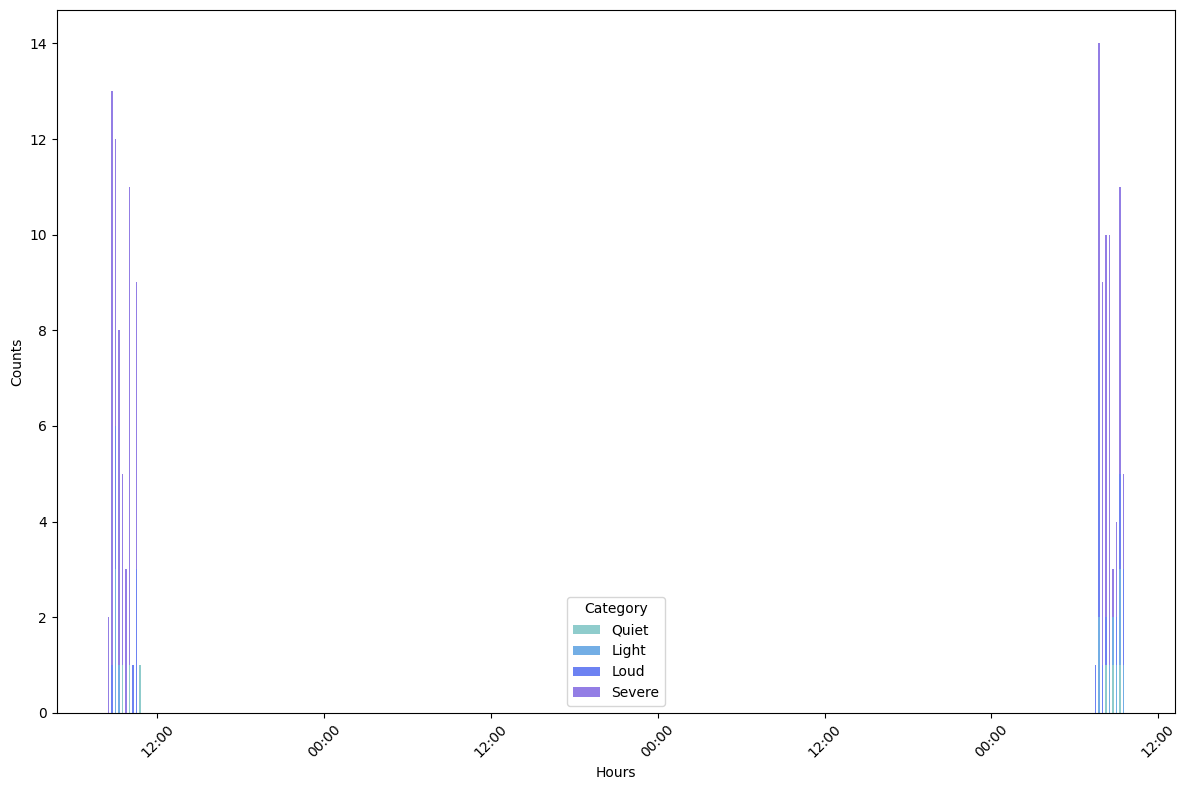

In [50]:
import matplotlib.dates as mdates


# plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table.index,
        pivot_table.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.005,
    )
    if bottom is None:
        bottom = pivot_table.get(category, 0)
    else:
        bottom += pivot_table.get(category, 0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

In [51]:
pivot_table_reset_index = pivot_table.reset_index()


api_json_object = json.loads(
    pivot_table_reset_index.to_json(orient="records", date_format="iso")
)


# with open("dump_graph.json", 'w') as f:
#     json.dump(api_json_object, f, indent=4)

# f.close()

api_json_object[:5]

[{'datetime': '2023-12-15T08:30:00.000',
  'Light': 0.0,
  'Loud': 0.0,
  'Quiet': 2.0,
  'Severe': 2.0},
 {'datetime': '2023-12-15T08:45:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 13.0,
  'Severe': 12.0},
 {'datetime': '2023-12-15T09:00:00.000',
  'Light': 3.0,
  'Loud': 3.0,
  'Quiet': 12.0,
  'Severe': 6.0},
 {'datetime': '2023-12-15T09:15:00.000',
  'Light': 1.0,
  'Loud': 0.0,
  'Quiet': 8.0,
  'Severe': 7.0},
 {'datetime': '2023-12-15T09:30:00.000',
  'Light': 0.0,
  'Loud': 0.0,
  'Quiet': 5.0,
  'Severe': 4.0}]

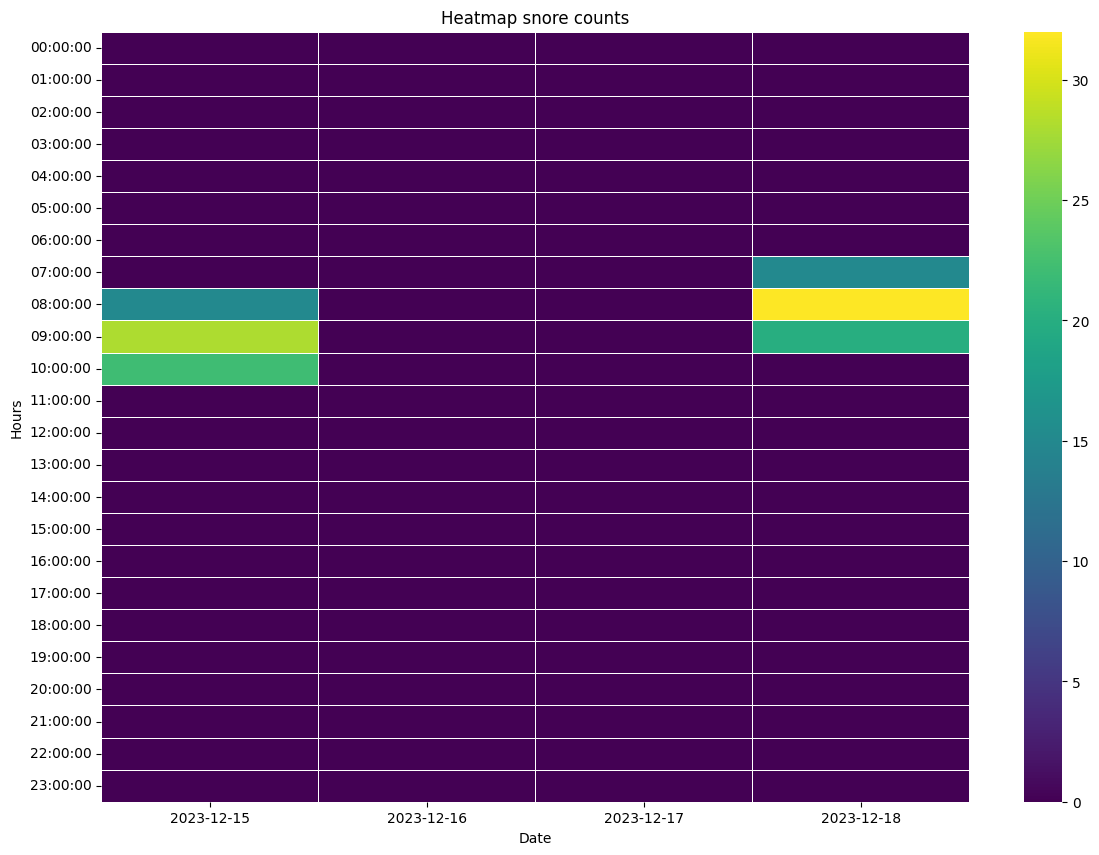

In [52]:
import seaborn as sns

counts["datetime"] = pd.to_datetime(counts["datetime"])

counts.set_index("datetime", inplace=True)
df_resampled_agg = counts.resample("60T").sum()
pivot_table = df_resampled_agg.pivot_table(
    index=df_resampled_agg.index.time,
    columns=df_resampled_agg.index.date,
    values="counts",
    aggfunc="sum",
)
pivot_table = pivot_table.fillna(0)


plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap="viridis", linewidths=0.5)
plt.title("Heatmap snore counts")
plt.xlabel("Date")
plt.ylabel("Hours")
plt.show()

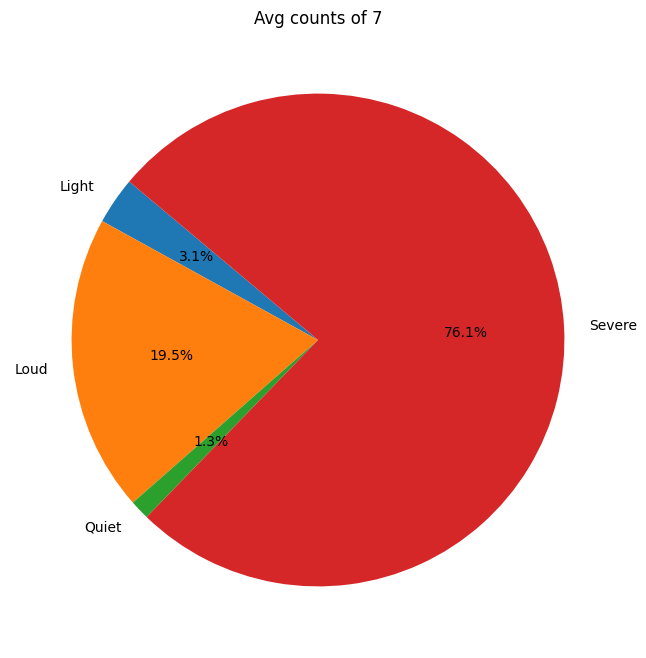

In [53]:
severity_counts = df.groupby("category")["snore_count"].sum()

severity_counts
plt.figure(figsize=(8, 8))
plt.pie(
    severity_counts, labels=severity_counts.index, autopct="%1.1f%%", startangle=140
)
plt.title("Avg counts of 7")
plt.show()

In [54]:
from math import pi

# radar chart?

data = pd.DataFrame(
    {
        "group": ["A"],
        "Quiet": [df[df["category"] == "Quiet"]["snore_count"].mean()],
        "Light": [df[df["category"] == "Light"]["snore_count"].mean()],
        "Loud": [df[df["category"] == "Loud"]["snore_count"].mean()],
        "Severe": [df[df["category"] == "Severe"]["snore_count"].mean()],
    }
)

values = data.loc[0].drop("group").values.flatten().tolist()
values += values[:1]

categories = data.drop("group", axis=1).columns.values.tolist()
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

angles

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]